In [53]:
import openTSNE
import utils

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [35]:
import gzip
import pickle

with gzip.open(path/"macosko_2015.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [39]:
x.shape

(44808, 50)

In [36]:
x

array([[ 9.96548965e+01, -8.12631530e+00, -9.25276252e+00, ...,
        -2.08936543e+01, -2.02527159e+01, -2.05730795e+01],
       [ 9.61668724e+01, -9.98573485e+00, -9.63782430e+00, ...,
        -1.18234345e+01, -1.13193308e+01, -8.18420056e+00],
       [ 9.49275546e+01, -8.51277823e+00, -7.50898581e+00, ...,
        -1.65388425e+01, -1.28309248e+01, -1.62688563e+01],
       ...,
       [ 1.31935002e+01, -3.11407532e+00, -2.28125403e+00, ...,
         4.37054780e+00,  4.04143397e+00,  3.07564637e+00],
       [-7.11957055e+00, -3.90842928e-01, -8.41815142e-01, ...,
         7.80651279e-01,  1.26566777e-01, -9.54569203e-02],
       [-8.13883956e+00, -2.03916579e-01, -5.48370748e-01, ...,
        -3.12829696e-03, -2.28520564e-02, -7.87714799e-02]])

In [44]:
x.shape, y.shape

((44808, 50), (44808,))

In [11]:
path = Path('data')

In [58]:
bulk = pd.read_csv(path/'sc_RNA_ct.csv', low_memory=False)
bulk = bulk.set_index('Unnamed: 0').T
bulk_tz = pd.read_csv(path/'sc_RNA_ZT.csv', low_memory=False).set_index('Unnamed: 0')
bulk.index = bulk.index.str.replace('.', '-')
bulk['code'] = bulk_tz
bulk['code'] = bulk.loc[:,'code'].str[-2:].map(int)
bulk

Unnamed: 0,Xkr4,Rp1,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Rb1cc1,4732440D04Rik,...,mt-Atp8,mt-Atp6,mt-Co3,mt-Nd3,mt-Nd4l,mt-Nd4,mt-Nd5,mt-Nd6,mt-Cytb,code
AAACAGCCAGCAATAA-8,0,0,0,0,1,0,0,0,2,0,...,0,1,4,0,0,0,0,0,2,18
AAACGCGCAGTATGTT-8,0,0,0,0,4,0,0,0,4,0,...,0,2,3,0,0,0,0,0,0,18
AAAGCGGGTGCATCGG-8,0,0,0,0,0,0,0,1,1,0,...,0,1,2,0,0,0,0,0,0,18
AAAGGACGTAAGGTTT-8,0,0,0,0,0,0,0,0,2,0,...,0,1,4,0,0,0,1,0,1,18
AAAGGAGCAACCGCCA-8,0,0,0,0,2,0,0,0,2,0,...,0,2,2,0,0,0,0,0,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTCCAAGTCTACTAAG-2,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,1,0,0,1,6
TACCGTTGTTACGCAA-2,0,0,0,0,1,0,0,0,0,1,...,0,1,3,0,1,1,0,0,1,6
TCCATCATCAGGTTTA-2,0,0,0,0,1,1,0,0,0,0,...,0,1,2,0,0,0,0,0,2,6
TCGTTAGCAGTAGGAT-2,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,1,0,0,0,6


In [59]:
x = bulk.iloc[:,:-1]
y = bulk["code"].astype(str)

In [47]:
x = x.reset_index(drop=True).values
x

array([[0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 3]])

In [48]:
embeddings = []

tsne = openTSNE.TSNE(
    perplexity=50, metric="cosine", n_jobs=32, verbose=True,
    # The embedding will be appended to the list we defined above, make sure we copy the
    # embedding, otherwise the same object reference will be stored for every iteration
    callbacks=lambda it, err, emb: embeddings.append(np.array(emb)),
    # This should be done on every iteration
    callbacks_every_iters=1,
)

In [49]:
%time tsne_embedding = tsne.fit(x)

--------------------------------------------------------------------------------
TSNE(callbacks=<function <lambda> at 0x7f24f8e13eb0>, callbacks_every_iters=1,
     early_exaggeration=12, metric='cosine', n_jobs=32, perplexity=50,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 150 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 694.49 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.39 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 4.91 seconds
===> Running optimization with exaggeration=12.00, lr=2172.33 for 250 iterations...
Iteration   50, KL divergence 5.1849, 50 iterations in 1.6151 sec
Iteration  100, KL divergence 4.7990, 50 iterations in 1.5976 sec
Iteration  150, KL divergence 4.7490, 50 iterations in 1.5902 sec
Iteration  200, KL divergence 4.7491, 50 iterations in 1.6258 sec
Iteration  250, KL divergence 4.6924, 50 iter

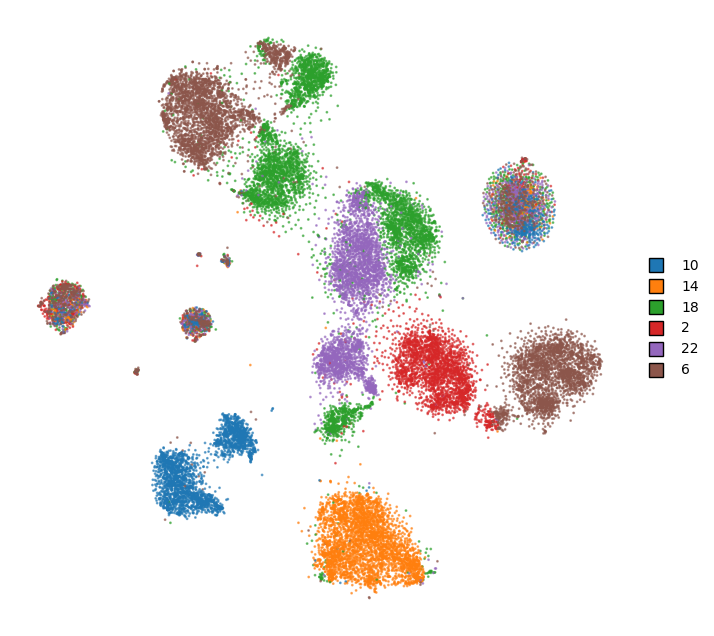

In [60]:
utils.plot(tsne_embedding, y)

In [61]:
%%time
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xticks([]), ax.set_yticks([])

colors = list(map(utils.MACOSKO_COLORS.get, y))
pathcol = ax.scatter(embeddings[0][:, 0], embeddings[0][:, 1], c=colors, s=1, rasterized=True)

def update(embedding, ax, pathcol):
    # Update point positions
    pathcol.set_offsets(embedding)
    
    # Adjust x/y limits so all the points are visible
    ax.set_xlim(np.min(embedding[:, 0]), np.max(embedding[:, 0]))
    ax.set_ylim(np.min(embedding[:, 1]), np.max(embedding[:, 1]))
    
    return [pathcol]

anim = animation.FuncAnimation(
    fig, update, fargs=(ax, pathcol), interval=20,
    frames=embeddings, blit=True,
)

anim.save("macosko.mp4", dpi=150, writer="ffmpeg")
plt.close()

CPU times: user 3min 11s, sys: 2.56 s, total: 3min 14s
Wall time: 3min 12s


In [ ]:
from IPython.display import display, HTML

display(HTML(anim.to_html5_video()))

In [ ]:
display(HTML(animate.to_html5_video()))